In [15]:
import numpy as np
import cv2
from scipy.spatial import distance
from scipy.ndimage.filters import convolve
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve
import argparse
from google.colab.patches import cv2_imshow
from argparse import RawTextHelpFormatter
import glob
from os import makedirs
from os.path import join, exists, basename, splitext
import cv2
import matplotlib.pyplot as plt
import pprint
import os
import ntpath

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

In [187]:
#default values
image_config={"be":1.0,"bs":1.0,"bc":1.0}       #1,1,1
image_config["size"]=15
image_config["sigma"]=5    #3
image_config["gamma"]=0.45   #0.6
image_config["lamda"]=0.15 #0.15
image_config["eps"]=1e-5
image_config["neighbour_dist"]=1  #1  
pprint.pprint(image_config)

{'bc': 1.0,
 'be': 1.0,
 'bs': 1.0,
 'eps': 1e-05,
 'gamma': 0.45,
 'lamda': 0.15,
 'neighbour_dist': 1,
 'sigma': 5,
 'size': 15}


In [17]:
def init_kernel_pixel(i, j,image_config):
    size = image_config["size"]
    spatial_sigma = image_config["sigma"]
    dist = distance.euclidean((i, j), (size // 2, size // 2)) ** 2
    ker_val = np.exp(-0.5 * dist / (spatial_sigma ** 2))
    return ker_val

def init_kernel(image_config):
    kernel = np.zeros((image_config["size"],image_config["size"]))
    kernel2 = np.zeros((image_config["size"],image_config["size"]))
    for i in range(image_config["size"]):
        for j in range(image_config["size"]):
            kernel[i, j] = init_kernel_pixel(i,j , image_config)
    
    return kernel

#print(init_kernel(image_config).shape)
image_config["kernel"] = init_kernel(image_config)

In [18]:
def get_neighbors(p, n, m):
    i, j = p // m, p % m
    nb_dist = image_config["neighbour_dist"]         
    d = {}
    if i + nb_dist < n:
        d[(i + nb_dist) * m + j] = (i + nb_dist, j, 0)
    if i - nb_dist >= 0:
        d[(i - nb_dist) * m + j] = (i - nb_dist, j, 0)
    
    if j + nb_dist < m:
        d[i * m + j + nb_dist] = (i, j + nb_dist, 1)
    if j - nb_dist >= 0:
        d[i * m + j - nb_dist] = (i, j - nb_dist, 1)
    
    return d

In [20]:
def forward_illumination(im,image_config):
    L = np.max(im, axis=2)                 #max of each channel
    L_refined = improved_L_map(L, image_config)
    L_refined_3d = np.stack((L_refined,)*3, axis=-1)
    im_corrected = np.true_divide(im ,L_refined_3d)    
    return im_corrected

#image = cv2.imread("low_light1.jpg")
#cv2_imshow(forward_illumination(image,image_config))

In [21]:
def illuminate_image(image,image_config):
    kernel=init_kernel(image_config)
    image_config["kernel"]=kernel

    im_normalized = image.astype(float) / 255.
    inv_im_normalized = 1 - im_normalized

    under_corrected = forward_illumination(im_normalized, image_config)    
    over_corrected_inv =  forward_illumination(inv_im_normalized, image_config)
    over_corrected = 1 - over_corrected_inv

    return under_corrected, over_corrected

#image = cv2.imread("low_light1.jpg")
#im1 , im2 = illuminate_image(image,image_config)
#cv2_imshow(image)
#cv2_imshow(im1*255)
#cv2_imshow(im2*255)

In [22]:
def improved_L_map(L, image_config):
    kernel = image_config["kernel"]

    Lp_h = cv2.Sobel(L, cv2.CV_64F, 1, 0, ksize=1)
    Lp_v = cv2.Sobel(L, cv2.CV_64F, 0, 1, ksize=1)

    T_h = convolve(np.ones(L.shape), kernel, mode='constant')
    T_h = T_h / (np.abs(convolve(Lp_h, kernel, mode='constant')) + image_config["eps"])

    T_v = convolve(np.ones(L.shape), kernel, mode='constant')
    T_v = T_v / (np.abs(convolve(Lp_v, kernel, mode='constant')) + image_config["eps"])

    wx=T_h / (np.abs(Lp_h) + image_config["eps"])
    wy=T_v / (np.abs(Lp_v) + image_config["eps"])

    
    L_1d = L.copy().flatten()
    row = []
    column = []
    data = []
    n, m = L.shape

    for p in range(0,n * m):
        diag = 0
        d = get_neighbors(p, n, m)
        for q in d:
            k, l, x = d[q]

            weight = wx[k, l] if x else wy[k, l]
            row.append(p)
            column.append(q)
            data.append(-weight)
            diag += weight
        row.append(p)
        column.append(p)
        data.append(diag)

    F = csr_matrix((data, (row, column)), shape=(n * m, n * m))

    Id = diags([np.ones(n * m)], [0])
    A = Id + image_config["lamda"] * F
    L_refined = spsolve(csr_matrix(A), L_1d, permc_spec=None, use_umfpack=True).reshape((n, m))

    L_refined = np.clip(L_refined, image_config["eps"], 1) ** image_config["gamma"]

    return L_refined

#image = cv2.imread("low_light1.jpg")
#L = np.max(image, axis=2)
#improved_L_map(L, image_config).shape

In [23]:
#assuming img2 and img3 are normalized by 255
#return value is multiplied by 255 beforehand
def merge(img1, img2, img3):
  merge_mertens = cv2.createMergeMertens(image_config["bc"], image_config["bs"], image_config["be"])
  images = [np.clip(x , 0, 255).astype("uint8") for x in [img1, img2* 255, img2* 255]]
  fused_images = merge_mertens.process(images)
  return fused_images*255

In [24]:
def correct_and_store_image(imgpath , output_dir = "outputs"):
    image = cv2.imread(imgpath)

    # create new directory for saving result
    if not exists(output_dir):
        makedirs(output_dir)

    enhanced_image1, enhanced_image2 = illuminate_image(image,image_config)
    fused_image = merge(image, enhanced_image1, enhanced_image2)

    name = ntpath.basename(imgpath)     #Extract file name from path, no matter what the os/path format
    name,ext = name.split(".")
    op_name = name + "_corrected." + ext
    
    cv2.imwrite(join(output_dir , op_name), fused_image)

    #return all 4 images as list
    return [image , enhanced_image1, enhanced_image2 , fused_image]

In [28]:
im_list = correct_and_store_image("overexp1.jpeg" , output_dir="mydir" )

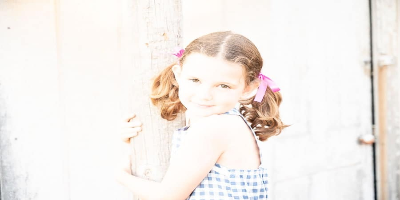

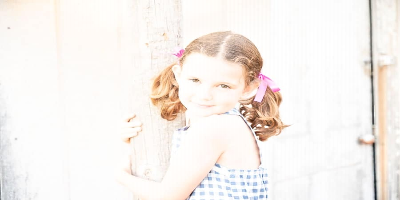

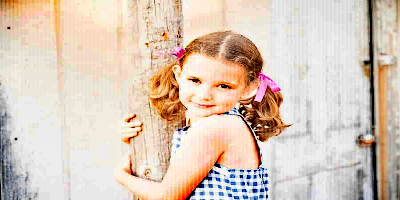

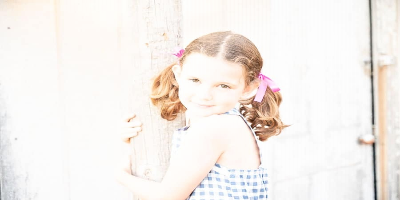

In [41]:
im_list = [cv2.resize(img , (400,200)) for img in im_list]
cv2_imshow(im_list[0])
cv2_imshow(im_list[1]*255)
cv2_imshow(im_list[2]*255)
cv2_imshow(im_list[3])

### Template code for any image

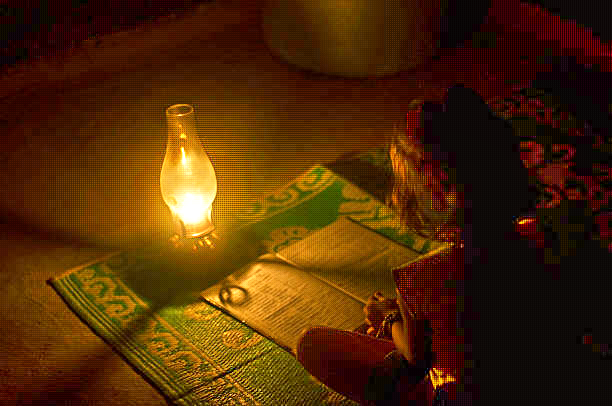

In [39]:
imgpath = "underexp2.jpeg"
image = cv2.imread(imgpath)
corr1 , corr2 = illuminate_image(image,image_config)
fused_images = merge(image, corr1, corr2)
cv2_imshow(fused_images)

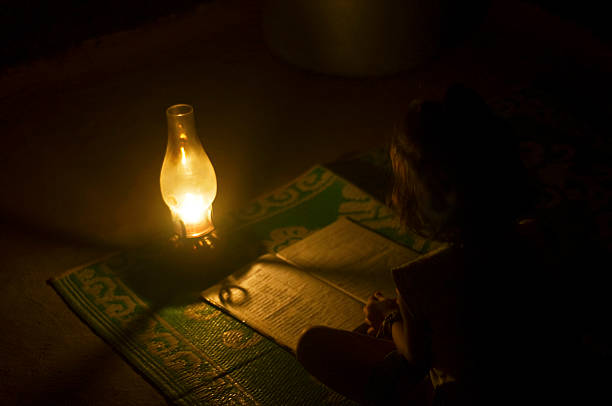

In [40]:
cv2_imshow(image)

## Histogram Equalization (Scratch)

In [192]:
#for 1 channel
def equalize_histogram(image):
    image_hist = np.zeros(256)
    #freq = np.zeros(256)
    image_flattened = image.flatten()
    
    #for i in range(256):
    #    freq[i] = (image==i).sum()

    for pix in image:
        image_hist[pix] += 1

    cum_sum = np.cumsum(image_hist)
    norm = (cum_sum - cum_sum.min())
    n = cum_sum.max() - cum_sum.min()
    uniform_norm = (norm * 255) / n
    uniform_norm = uniform_norm.astype('int')

    image_eq = uniform_norm[image_flattened]
    image_eq = np.reshape(image_eq, image.shape)

    return image_eq

In [193]:
def contrast_enhance(image_src, gray_scale=False):
    if not gray_scale:
        ch_list = []
        for i in range(3):
            ch_image = image_src[:, :, i]
            ch_image_eq = equalize_histogram(ch_image)
            ch_list.append(ch_image_eq)

        image_eq = np.dstack(ch_list)
    return image_eq

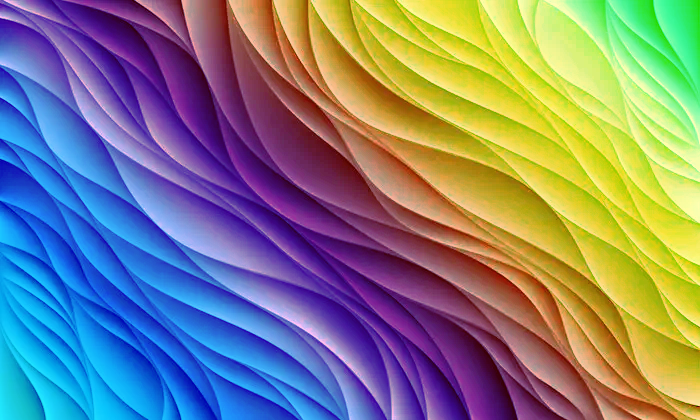

In [199]:
imgpath = "normal2.jpeg"
image = cv2.imread(imgpath)
enh_img = contrast_enhance(image)

cv2_imshow(enh_img)

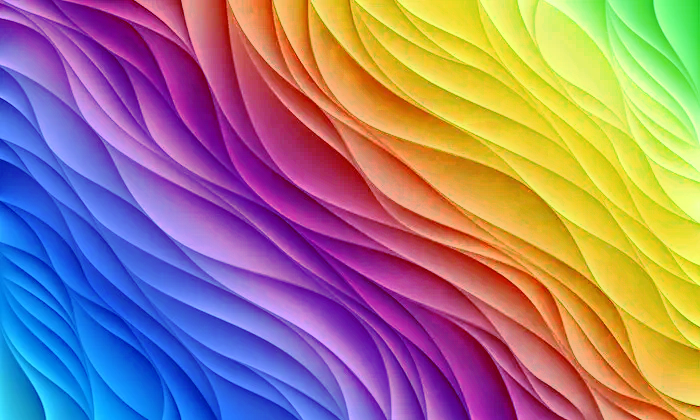

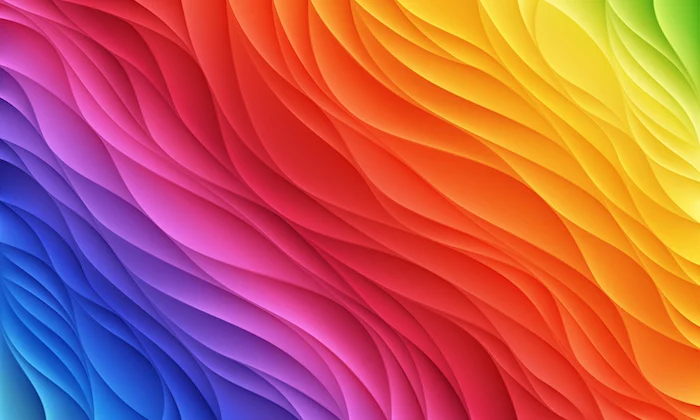

In [200]:
corr1 , corr2 = illuminate_image(enh_img,image_config)
fused_images = merge(image, corr1, corr2)
cv2_imshow(fused_images)
cv2_imshow(image)

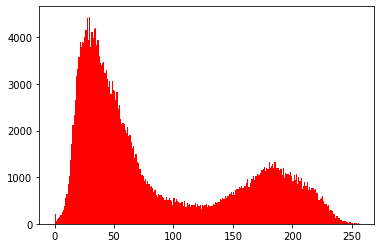

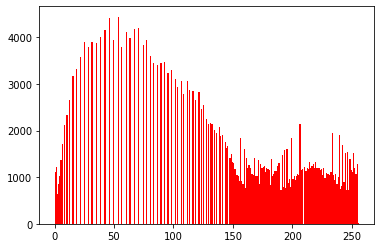

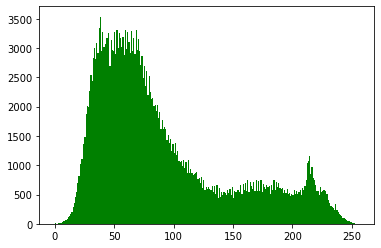

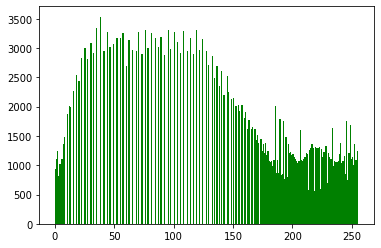

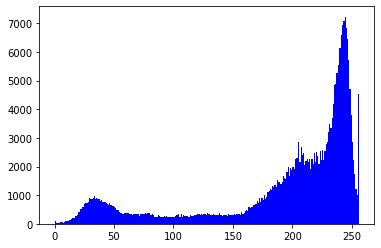

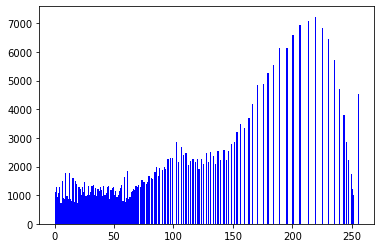

In [202]:
color_list = ["red" , "green" , "blue"]
for i in range(3):
    plt.hist(image[:,:,i].flatten(),256,[0,256], color = color_list[i])
    plt.show()
    plt.hist(enh_img[:,:,i].flatten(),256,[0,256], color = color_list[i])
    plt.show()

# Breakpoint

In [ ]:

import numpy as np
import cv2 as cv
video = []
corrected_video = []

#fourcc = cv.VideoWriter_fourcc(*'XVID')
#out = cv.VideoWriter('/content/drive/My Drive/COMPUTER VISION/project/output.mp4', fourcc, 20.0, (352,  640))

cap = cv.VideoCapture("/content/drive/My Drive/COMPUTER VISION/project/vid1.mp4")
if (not cap.isOpened()): 
    print("Cannot open camera")
    exit()
i = 0
while True:
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    #gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    print(i, frame.shape)
    i+=1
    video.append(frame)
    #out.write(frame)

video = np.array(video)
print(video.shape)


In [ ]:
video.shape

(152, 352, 640, 3)

In [ ]:
corrected_video = []

for idx, frame in enumerate(video):
  print(idx, frame.shape)
  enhanced_image1, enhanced_image2 = illuminate_image(frame,image_config)
  out_frame = merge(frame, enhanced_image1, enhanced_image2)
  corrected_video.append(out_frame)
corrected_video = np.array(corrected_video)
print(corrected_video.shape)

In [ ]:
corrected_video.shape

(152, 352, 640, 3)

In [ ]:
def generate_video():
    image_folder = '/content/drive/My Drive/COMPUTER VISION/project/video_imgs/' # make sure to use your folder
    video_name = '/content/drive/My Drive/COMPUTER VISION/project/mygeneratedvideo2.avi'
    #os.chdir("/content/drive/My Drive/COMPUTER VISION/project/video_imgs/")
      
    images = [img for img in os.listdir(image_folder)
              if img.endswith(".jpg") or
                 img.endswith(".jpeg") or
                 img.endswith("png")]
     
    # Array images should only consider
    # the image files ignoring others if any
    print(images) 
    
    frame = cv2.imread(os.path.join(image_folder, images[0]))
  
    # setting the frame width, height width
    # the width, height of first image
    height, width, layers = frame.shape  
    fourcc = cv.VideoWriter_fourcc(*'XVID')
  
    video = cv2.VideoWriter(video_name, fourcc, 30, (width, height)) 
  
    # Appending the images to the video one by one
    for image in images: 
        video.write(cv2.imread(os.path.join(image_folder, image))) 
    
generate_video()


['0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '64.jpg', '65.jpg', '66.jpg', '67.jpg', '68.jpg', '69.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg', '76.jpg', '77.jpg', '78.jpg', '79.jpg', '80.jpg', '81.jpg', '82.jpg', '83.jpg', '84.jpg', '85.jpg', '86.jpg', '87.jpg', '88.jpg', '89.jpg', '90.jpg', '91.jpg', '92.jpg', '93.jpg', '94.jpg', '95.jpg', '96.jpg', '97.jpg', '98.jpg', '99.jpg', '100.jpg'